Noise Types:
- pr: POS-guided word replacement
- sr: synonym replacement
- ri: random insertion
- rs: random swap
- rd: random deletion

In [10]:
import matplotlib.pyplot as plt
import json

In [11]:
def map_noise_type(noise_type):
    mapping = {
        'psr': 'Synonym Replacement',
        'ppr': 'POS-Tag Replacement',
        'pri': 'Random Insertion',
        'prs': 'Random Swap',
        'prd': 'Random Deletion'
    }
    return mapping[noise_type]

In [12]:
with open('../out/robustness_study/results_bert_teacher.json', 'r') as f:
    results_bert_teacher = json.load(f)
with open('../out/robustness_study/results_bert_student.json', 'r') as f:
    results_bert_student = json.load(f)

In [27]:
def plot_noise_type_f1_vs_ece(noise_type: str):   
    # TODO: add confidence intervals to the plots
    levels = sorted(results_bert_teacher[noise_type].keys())
    f1_scores_teacher = [results_bert_teacher[noise_type][level]['f1_score'] for level in levels]
    f1_scores_student = [results_bert_student[noise_type][level]['f1_score'] for level in levels]
    ece_scores_teacher = [results_bert_teacher[noise_type][level]['ece_score'] for level in levels]
    ece_scores_student = [results_bert_student[noise_type][level]['ece_score'] for level in levels]
    
    # add std dev candles
    f1_scores_teacher_std = [results_bert_teacher[noise_type][level]['f1_score_std'] for level in levels]
    f1_scores_student_std = [results_bert_student[noise_type][level]['f1_score_std'] for level in levels]
    ece_scores_teacher_std = [results_bert_teacher[noise_type][level]['ece_score_std'] for level in levels]
    ece_scores_student_std = [results_bert_student[noise_type][level]['ece_score_std'] for level in levels]
    
    # confidence intervals
    t = 1.96
    f1_scores_teacher_std = [t * std for std in f1_scores_teacher_std]
    f1_scores_student_std = [t * std for std in f1_scores_student_std]
    ece_scores_teacher_std = [t * std for std in ece_scores_teacher_std]
    ece_scores_student_std = [t * std for std in ece_scores_student_std]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # F1 Scores
    ax1.set_xlabel('Noise Level')
    ax1.set_ylabel('F1 Score', color='tab:blue')
    ax1.plot(levels, f1_scores_teacher, label='Teacher F1', marker='o', color='tab:blue')
    ax1.plot(levels, f1_scores_student, label='Student F1', marker='x', linestyle='--', color='tab:blue')
    # plot confidence intervals as area around the line
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], [f1 + std for f1, std in zip(f1_scores_teacher, f1_scores_teacher_std)], color='tab:blue', alpha=0.2)
    ax1.fill_between(levels, [f1 - std for f1, std in zip(f1_scores_student, f1_scores_student_std)], [f1 + std for f1, std in zip(f1_scores_student, f1_scores_student_std)], color='tab:blue', alpha=0.2)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('ECE', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(levels, ece_scores_teacher, label='Teacher ECE', marker='o', color='tab:red')
    ax2.plot(levels, ece_scores_student, label='Student ECE', marker='x', linestyle='--', color='tab:red')
    # plot confidence intervals as area around the line
    ax2.fill_between(levels, [ece - std for ece, std in zip(ece_scores_teacher, ece_scores_teacher_std)], [ece + std for ece, std in zip(ece_scores_teacher, ece_scores_teacher_std)], color='tab:red', alpha=0.2)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.title(f'Performance Comparison for {map_noise_type(noise_type)}')
    plt.show()

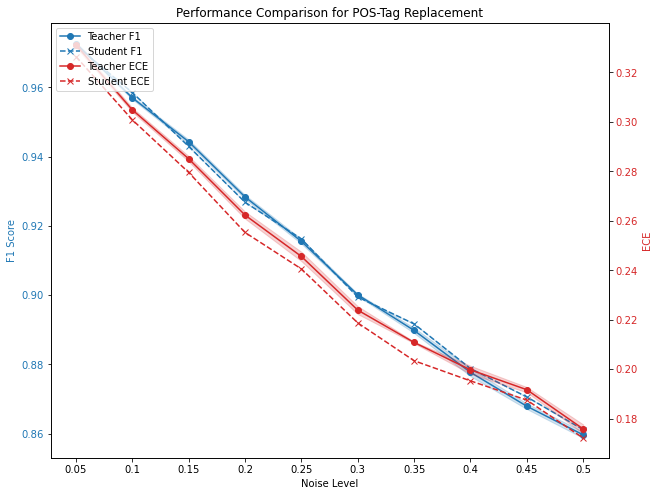

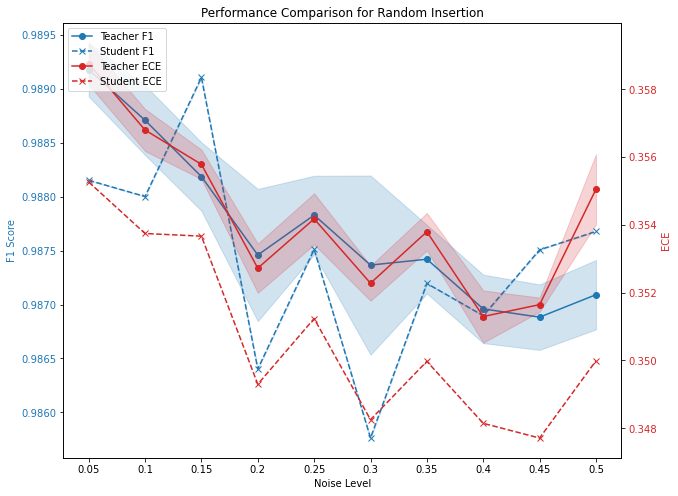

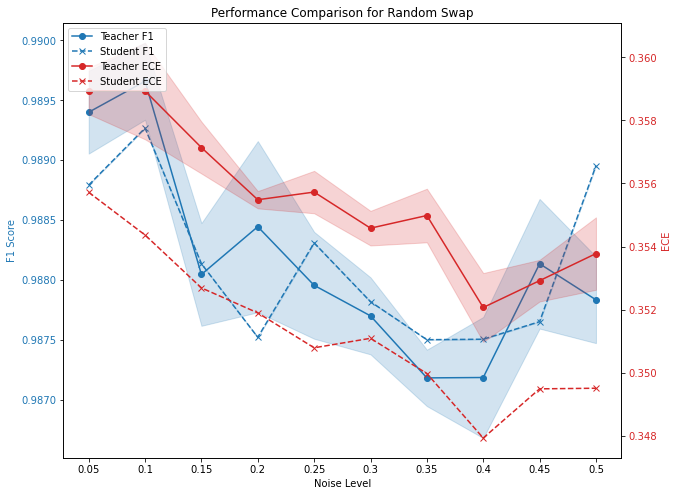

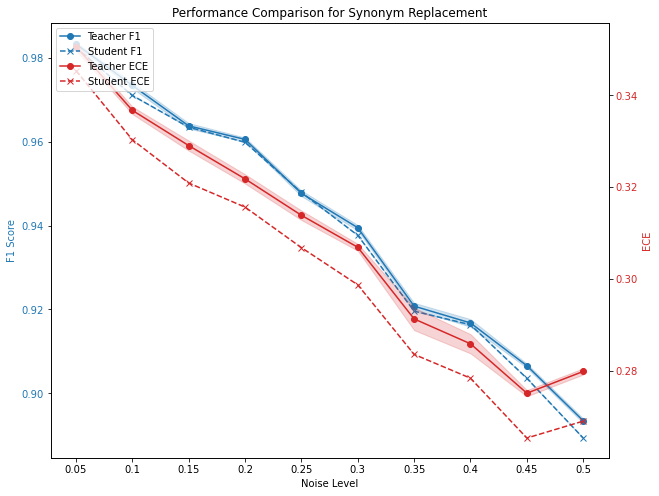

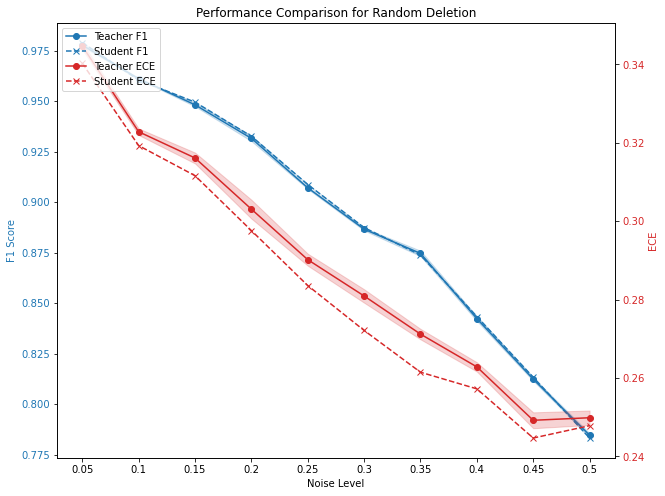

In [28]:
for noise_type in results_bert_teacher.keys():
    plot_noise_type_f1_vs_ece(noise_type)

- analyze further, especially after averaging over multiple runs
- see if teacher outperforms student anywhere 
-> if not, then uncertainty distillation was already complete success
-> if yes, then we can use the respective noise type to augment the transfer dataset and retrain the student, hoping for better performance

- random swap / random insertion patterns maybe due to artifacts in the perturbed data (given that random insertion especially can lead to nonsensical sentences) and random swap can heavily change the meaning of a sentence in some instances (look for examples)

- first idea, also looking at brier score vs f1 below: use light random swap and random insertion (prob 0.1) as augmentations
- here, teacher outperforms student in terms of predictive performance (f1), as well as in terms of calibration (brier score, ECE)
--> confirm with new results

In [15]:
def plot_noise_type_f1_vs_brier(noise_type: str):    
    levels = sorted(results_bert_teacher[noise_type].keys())
    f1_scores_teacher = [results_bert_teacher[noise_type][level]['f1_score'] for level in levels]
    f1_scores_student = [results_bert_student[noise_type][level]['f1_score'] for level in levels]
    ece_scores_teacher = [results_bert_teacher[noise_type][level]['brier_score'] for level in levels]
    ece_scores_student = [results_bert_student[noise_type][level]['brier_score'] for level in levels]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    # F1 Scores
    ax1.set_xlabel('Noise Level')
    ax1.set_ylabel('F1 Score', color='tab:blue')
    ax1.plot(levels, f1_scores_teacher, label='Teacher F1', marker='o', color='tab:blue')
    ax1.plot(levels, f1_scores_student, label='Student F1', marker='x', linestyle='--', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Brier Score', color='tab:red')  # we already handled the x-label with ax1
    ax2.plot(levels, ece_scores_teacher, label='Teacher Brier Score', marker='o', color='tab:red')
    ax2.plot(levels, ece_scores_student, label='Student Brier Score', marker='x', linestyle='--', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.title(f'Performance Comparison for {map_noise_type(noise_type)}')
    plt.show()

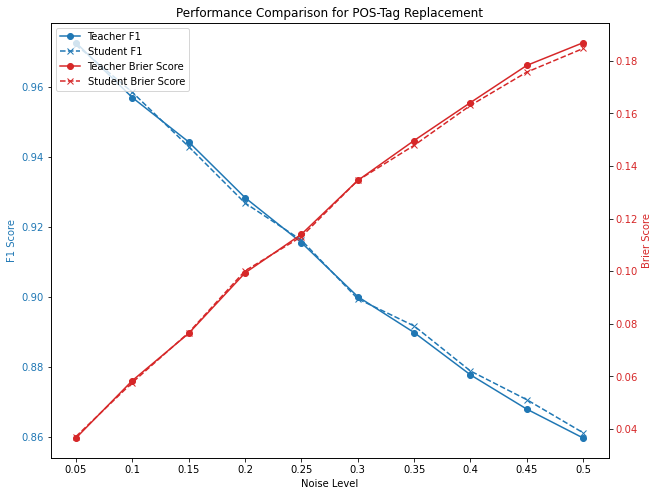

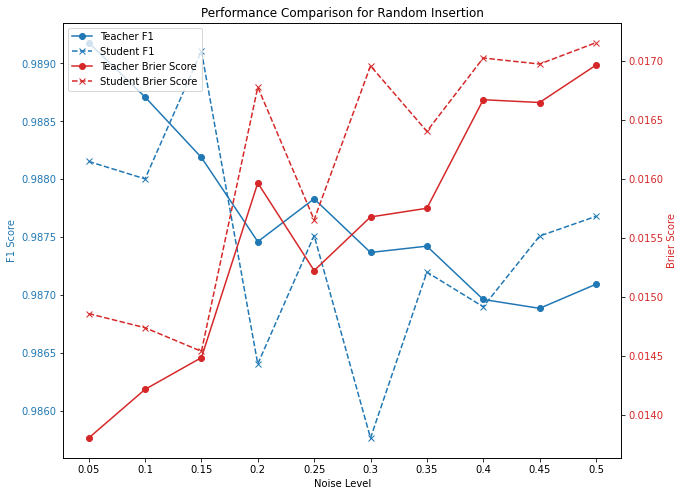

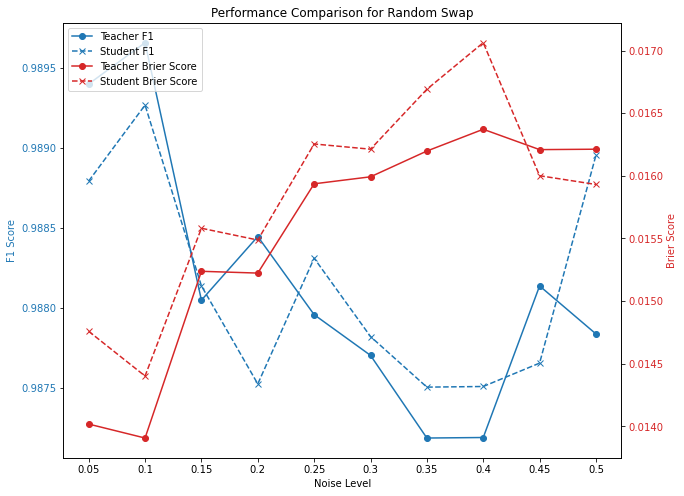

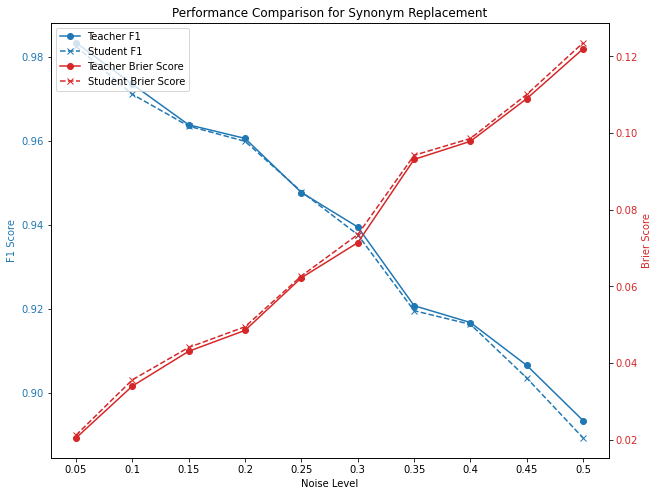

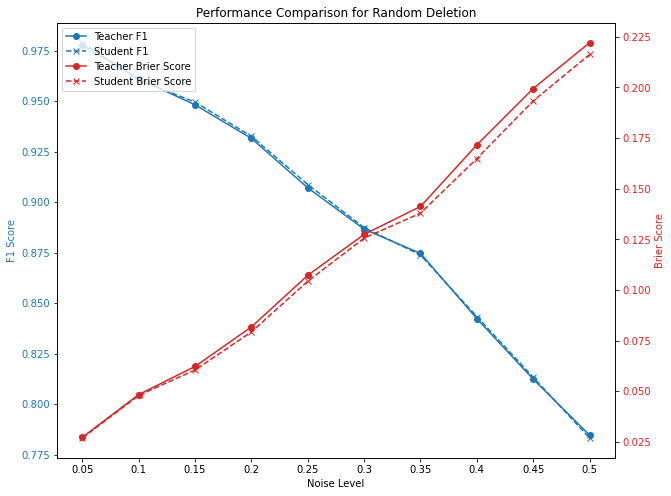

In [16]:
for noise_type in results_bert_teacher.keys():
    plot_noise_type_f1_vs_brier(noise_type)